# Getting the most solar power for your dollar
## Data wrangling
### Zachary Brown

The goal of this project is to use the Tracking the Sun dataset from the Lawrence Berkeley National Laboratory to create a model that identifies what factors make residential solar panel installations in Austin, Texas as cost-efficient as possible. To do so the data will be loaded from Parquet files and in this notebook will be wrangled into the working dataframe for the rest of the project.

I'll start off by importing the modules needed for importing and wrangling the data.

In [1]:
import os
import wget
import requests
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
from datetime import datetime

Next I need to download the Parquet datafiles into the external data directory within this repository, so I'll switch to the correct directory.

In [2]:
print(os.getcwd())
os.chdir(r"..\data\external")
data_dir = os.getcwd()
print(os.getcwd())

C:\Users\Zachary Brown\Documents\GitHub\Solar-Panel-Capstone\notebooks
C:\Users\Zachary Brown\Documents\GitHub\Solar-Panel-Capstone\data\external


The next step is to download the parquet files. The entire collection of data is hosted here: https://data.openei.org/s3_viewer?bucket=oedi-data-lake&prefix=tracking-the-sun%2F

I only need 2021 data for this project as I want the most up to date model possible. Within 2021 the data is broken down by state. I need to download all 26 files, so I'll create a function to automatically download them all for me.

In [3]:
# Start by creating the function and creating empty url and file name lists

def import_data(root_url):
    urls = []
    file_names = []
    
# Parse the 2021 data directory to get URLs for each state    

    response = requests.get(root_url)
    soup = BeautifulSoup(response.content, "html.parser")
    
    for a in soup.find_all('a', href=True):
        if '/s3_viewer?bucket=oedi-data-lake&prefix=tracking-the-sun%2F' in a['href']:
            urls.append('https://data.openei.org' + a['href'])
    
# Create a list of the file names for each state from each link in the urls list

    for url in urls:
        url_response = requests.get(url)
        url_soup = BeautifulSoup(url_response.content, 'html.parser')
        
        for a in url_soup.find_all('a', href=True):
            if '.parquet' in a['href']:
                file_names.append(a['href'])
            
# Loop through each file and download to data directory

    for url, file in zip(urls, file_names):
        wget.download(file)

Now that the function has been created to download all of the Parquet files locally we need to run it with the 2021 URL to download the state data files.

In [4]:
import_data('https://data.openei.org/s3_viewer?bucket=oedi-data-lake&prefix=tracking-the-sun%2F2021%2F')

Now the data files need to be loaded into a single Pandas dataframe to begin the wrangling process.

In [21]:
file_list = []

# I'll start by adding each Parquet file to an empty list.
for file in os.listdir(data_dir):
    if file.endswith('.parquet'):
        file_list.append(file)
        
# Now I'll iterate over the file_list and read each in to one dataframe, aggregating all of the data.
tables = []

for filename in file_list:
    df = pd.read_parquet(filename)
    tables.append(df)

raw_data = pd.concat(tables, ignore_index=True)
raw_data.head()

,data_provider_1,data_provider_2,system_id_1,system_id_2,installation_date,system_size_dc,total_installed_price,rebate_or_grant,customer_segment,expansion_system,...,output_capacity_inverter_1,output_capacity_inverter_2,output_capacity_inverter_3,dc_optimizer,inverter_loading_ratio,date_of_battery_install,battery_manufacturer,battery_model,battery_rated_capacity_kw,battery_rated_capacity_kwh
0,"Washington, D.C. Public Service Commission",-1,DC-2012700-SUN-I,-1,2020-11-30,6.80,-1.0,-1.0,-1,0,...,-1.0,-1.0,-1.0,-1,-1.0,NaT,-1,-1,-1.0,-1.0
1,"Washington, D.C. Public Service Commission",-1,DC-2012701-SUN-I,-1,2020-12-07,7.04,-1.0,-1.0,-1,0,...,-1.0,-1.0,-1.0,-1,-1.0,NaT,-1,-1,-1.0,-1.0
2,"Washington, D.C. Public Service Commission",-1,DC-2012702-SUN-I,-1,2020-12-07,7.68,-1.0,-1.0,-1,0,...,-1.0,-1.0,-1.0,-1,-1.0,NaT,-1,-1,-1.0,-1.0
3,"Washington, D.C. Public Service Commission",-1,DC-2012703-SUN-I,-1,2020-12-06,5.12,-1.0,-1.0,-1,0,...,-1.0,-1.0,-1.0,-1,-1.0,NaT,-1,-1,-1.0,-1.0
4,"Washington, D.C. Public Service Commission",-1,DC-2012704-SUN-I,-1,2020-12-07,5.76,-1.0,-1.0,-1,0,...,-1.0,-1.0,-1.0,-1,-1.0,NaT,-1,-1,-1.0,-1.0


Ok, now that the dataframe has been assembled it's time to explore it.

In [22]:
raw_data.shape

(2041551, 80)

In [23]:
raw_data.columns

Index(['data_provider_1', 'data_provider_2', 'system_id_1', 'system_id_2',
       'installation_date', 'system_size_dc', 'total_installed_price',
       'rebate_or_grant', 'customer_segment', 'expansion_system',
       'multiple_phase_system', 'new_construction', 'tracking',
       'ground_mounted', 'zip_code', 'city', 'utility_service_territory',
       'third_party_owned', 'installer_name', 'self_installed', 'azimuth_1',
       'azimuth_2', 'azimuth_3', 'tilt_1', 'tilt_2', 'tilt_3',
       'module_manufacturer_1', 'module_model_1', 'module_quantity_1',
       'module_manufacturer_2', 'module_model_2', 'module_quantity_2',
       'module_manufacturer_3', 'module_model_3', 'module_quantity_3',
       'additional_modules', 'technology_module_1', 'technology_module_2',
       'technology_module_3', 'bipv_module_1', 'bipv_module_2',
       'bipv_module_3', 'bifacial_module_1', 'bifacial_module_2',
       'bifacial_module_3', 'nameplate_capacity_module_1',
       'nameplate_capacity_module

In [24]:
col = raw_data.columns.to_series().groupby(df.dtypes).groups
print(col)

{datetime64[ns]: ['installation_date', 'date_of_battery_install'], int32: ['expansion_system', 'multiple_phase_system', 'new_construction', 'tracking', 'ground_mounted', 'third_party_owned', 'self_installed', 'module_quantity_1', 'module_quantity_2', 'module_quantity_3', 'additional_modules', 'bipv_module_1', 'bipv_module_2', 'bipv_module_3', 'bifacial_module_1', 'bifacial_module_2', 'bifacial_module_3', 'nameplate_capacity_module_1', 'nameplate_capacity_module_2', 'nameplate_capacity_module_3', 'inverter_quantity_2', 'inverter_quantity_3', 'additional_inverters', 'micro_inverter_1', 'micro_inverter_2', 'micro_inverter_3', 'solar_storage_hybrid_inverter_1', 'solar_storage_hybrid_inverter_2', 'solar_storage_hybrid_inverter_3', 'built_in_meter_inverter_1', 'built_in_meter_inverter_2', 'built_in_meter_inverter_3', 'output_capacity_inverter_2', 'output_capacity_inverter_3', 'dc_optimizer'], float64: ['system_size_dc', 'total_installed_price', 'rebate_or_grant', 'azimuth_1', 'azimuth_2', 'a

Right now I'm missing a state column, and zip code is object type when it seems like it should be an integer.

First I'll check to see if any zip codes are longer than the expected 5 digits.

In [25]:
long_zip = raw_data[raw_data['zip_code'].str.len() > 5]
long_zip['zip_code'].head()

13032    55106-2804
13035    55113-6301
13038    55981-9646
13055    56085-3003
13058    56085-3003
Name: zip_code, dtype: object

Ok, so it's an object because it includes 9-digit zip codes. That's fine, I'll leave it unchanged for now. 

Before I create a state column I'll pare down the data to only applicable rows. This means just residential installations from 2021 that are not missing 'total_installed_price' values

In [26]:
print(raw_data['customer_segment'].unique())

['-1' 'RES' 'NON-PROFIT' 'SCHOOL' 'GOV' 'NON-RES' 'COM']


In [27]:
# Now I'll subset the data to just residential installations
res_data = raw_data[raw_data['customer_segment'] == 'RES']
res_data.shape

(1948072, 80)

In [20]:
res_copy = res_data.copy()
res_copy['year'] = res_copy.installation_date.dt.year
res_copy['year'].value_counts().sort_index()

1971.0         2
1985.0         6
1986.0        12
1988.0        10
1989.0        10
1990.0        12
1991.0        20
1992.0        16
1993.0         8
1994.0        14
1995.0        20
1996.0        16
1997.0        24
1998.0        64
1999.0       340
2000.0       350
2001.0      2278
2002.0      4362
2003.0      5636
2004.0      9912
2005.0     10104
2006.0     16618
2007.0     24994
2008.0     28788
2009.0     52534
2010.0     73382
2011.0     95166
2012.0    132930
2013.0    206476
2014.0    309638
2015.0    491072
2016.0    556674
2017.0    437194
2018.0    446942
2019.0    481632
2020.0    476454
2021.0      4532
2106.0        16
Name: year, dtype: int64

Interestingly it looks like there's not actually very much 2021 data in the Parquet files, so I'll use 2020 and 2021 data together to build the model for this project. 

In [28]:
newest_data = res_copy[res_copy['installation_date'].dt.year.isin([2020, 2021])]
newest_data.shape

(480986, 81)

Next I want to check how many rows are missing 'total_installed_price' data and remove them since that price is key to calculating the final installed price, which is the key metric for the model. Missing values are indicated as -1 in this dataset.

In [29]:
newest_data['total_installed_price'].value_counts().sort_index()

-1.00          64058
 0.01             16
 0.10              2
 1.00           3874
 3.25             18
               ...  
 3680000.00        2
 4789800.00        2
 7485834.00        2
 8255000.00        2
 9887777.00        2
Name: total_installed_price, Length: 78725, dtype: int64

While I don't believe that any solar panel installations actually cost $0.01, $0.10, or $1.00, I don't know for sure why they're in there, so I'll check a plot to see if there's an obvious divide between erroneous values and realistic ones. Since price will most likely be linked to 'module_quantity_1' I'll create a scatterplot and look for low price points that appear to be outliers.

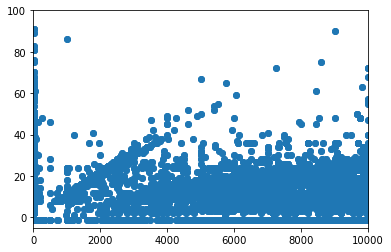

In [36]:
plt.scatter(newest_data['total_installed_price'],newest_data['module_quantity_1'])
plt.xlim(-5, 10000)
plt.ylim([-5,100])
plt.show()

As crowded as this plot is, there is an obvious linear correlation in there, and there is also so much variation that there is no easy way to tell what can be considered an outlier at low price points. I'll just remove rows with missing (-1) values in 'total_installed_price' for now.

In [37]:
missing_sale = newest_data['total_installed_price'] == -1
newest_data = newest_data[~missing_sale]
newest_data.shape

(416928, 81)

Now I want to check the proportion of each column that is missing data. I may be able to remove some columns if they are mostly missing values that will skew the model.

In [53]:
print((newest_data[newest_data == -1].count() / newest_data.count() * 100).sort_values(ascending=False).to_string())

output_capacity_inverter_3         99.968298
inverter_quantity_3                99.952510
solar_storage_hybrid_inverter_3    99.865684
built_in_meter_inverter_3          99.834504
micro_inverter_3                   99.834504
output_capacity_inverter_2         99.833291
inverter_quantity_2                98.866951
solar_storage_hybrid_inverter_2    98.795475
built_in_meter_inverter_2          98.743668
micro_inverter_2                   98.743668
tilt_3                             98.074008
azimuth_3                          98.074008
module_quantity_3                  97.879250
efficiency_module_3                97.797701
nameplate_capacity_module_3        97.784686
bipv_module_3                      97.782831
bifacial_module_3                  97.781871
new_construction                   95.320535
azimuth_2                          94.972753
tilt_2                             94.972753
battery_rated_capacity_kwh         94.037340
module_quantity_2                  93.873762
efficiency

In [44]:
newest_data.count()

data_provider_1               416928
data_provider_2               416928
system_id_1                   416928
system_id_2                   416928
installation_date             416928
                               ...  
battery_manufacturer          416928
battery_model                 416928
battery_rated_capacity_kw     416928
battery_rated_capacity_kwh    416928
year                          416928
Length: 81, dtype: int64